# LAB 4 MOS: Método Simplex y sus Variaciones

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 1: Implementación del Método Simplex Estándar

$$Maximizar \quad Z = 3x_1 + 2x_2 + 5x_3$$

Restricciones:

$$x_1 + x_2 + x_3 \leq 100$$
$$2x_1 + x_2 + x_3 \leq 150$$
$$x_1 + 4x_2 + 2x_3 \leq 80$$
$$x_1, x_2, x_3 \geq 0$$

### Convertir el problema a forma estandar con variables de holgura:

$$Z = 3x_1 + 2x_2 + 5x_3 + 0s_1 + 0s_2 + 0s_3$$

Restricciones:

$$x_1 + x_2 + x_3 + s_1 = 100$$
$$2x_1 + x_2 + x_3 + s_2 = 150$$
$$x_1 + 4x_2 + 2x_3 + s_3 = 80$$
$$x_1, x_2, x_3, s_1, s_2, s_3 \geq 0$$

### Implementación de Simplex:

Tabla Simplex Inicial:
+------+------+------+------+------+------+-----+
|   x1 |   x2 |   x3 |   s1 |   s2 |   s3 |   b |
+======+======+======+======+======+======+=====+
|    1 |    1 |    1 |    1 |    0 |    0 | 100 |
+------+------+------+------+------+------+-----+
|    2 |    1 |    1 |    0 |    1 |    0 | 150 |
+------+------+------+------+------+------+-----+
|    1 |    4 |    2 |    0 |    0 |    1 |  80 |
+------+------+------+------+------+------+-----+
|   -3 |   -2 |   -5 |    0 |    0 |    0 |   0 |
+------+------+------+------+------+------+-----+


Iteración 1: Variable que entra: 3, Variable que sale: 3
Tabla Simplex actualizada:
+------+------+------+------+------+------+-----+
|   x1 |   x2 |   x3 |   s1 |   s2 |   s3 |   b |
+======+======+======+======+======+======+=====+
|  0.5 |   -1 |    0 |    1 |    0 | -0.5 |  60 |
+------+------+------+------+------+------+-----+
|  1.5 |   -1 |    0 |    0 |    1 | -0.5 | 110 |
+------+------+------+------+------+-----

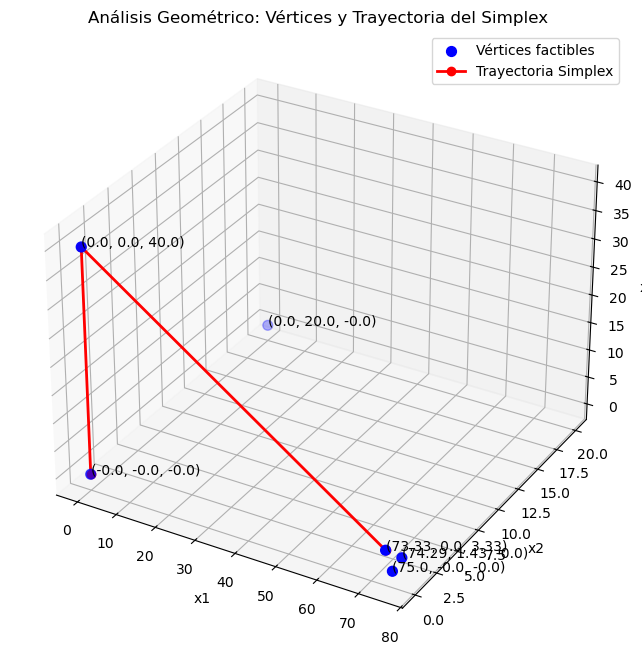

In [3]:
import numpy as np
from tabulate import tabulate
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def simplex(c, A, b, imprimir_iteraciones=True):
    m, n = A.shape  # m es el número de restricciones, n es el número de variables
    # tabla que contendra las iteraciones
    tableau = np.hstack((A, np.eye(m), b.reshape(-1, 1))) # Restricciones A, identidad de holgura y vector b
    obj_row = np.hstack((-c, np.zeros(m+1))) # Coeficientes de funcion objetivo
    tableau = np.vstack((tableau, obj_row)) # Anadirlos a la tabla
    basis = list(range(n, n+m)) # Variables basicas iniciales
    iterates = [] # Guarda las soluciones para cada iteracion

    # Funcion para extraer solucion de la tabla
    def extraer_solucion(tableau, basis):
        sol = np.zeros(n) # Solucion inicializada en cero
        for i in range(m):
            if basis[i] < n: # Si variable basica esta entre variables originales
                sol[basis[i]] = tableau[i, -1] # Se asigna el valor solucion a esa posicion
        return sol

    iterates.append(extraer_solucion(tableau, basis)) # Tomar solucion inicial

    if imprimir_iteraciones: # Imprimir la iteracion 0 (tabulate)
        print("Tabla Simplex Inicial:")
        headers = [f"x{i+1}" for i in range(n)] + [f"s{i+1}" for i in range(m)] + ["b"]
        print(tabulate(tableau, headers=headers, tablefmt="grid"))
        print("\n")

    # Ciclo principal para simplex
    iteration = 0 # Contador de iteraciones
    while True:
        iteration += 1
        obj_coeff = tableau[-1, :-1] # Tomar los coeficientes de la función objetivo
        if all(obj_coeff >= 0): # Si todos los coeficientes no son negativos, se llego a la solucion
            break # Salir
        
        # Se selecciona la variable de entrada
        entering = np.argmin(obj_coeff) # La mas negativa
        column = tableau[:-1, entering] # Se toma su columna
        if all(column <= 0): # Si todos sus valores son negativos, el problema es ilimitado
            raise Exception("El problema es ilimitado.") # Salir (con exception)

        #Para la variable que sale, calcular las razones
        ratios = [tableau[i, -1] / tableau[i, entering] if tableau[i, entering] > 0 else np.inf for i in range(m)]
        # Seleccionar la que tiene razon minima
        leaving = np.argmin(ratios)

        # Mostrar la variable que entra y sale
        if imprimir_iteraciones:
            print(f"Iteración {iteration}: Variable que entra: {entering+1}, Variable que sale: {leaving+1}")

        # Pivote de la iteracion
        pivot = tableau[leaving, entering]
        tableau[leaving, :] /= pivot # Normalizar la fila del pivote
        # Ciclo para actualizar las filas
        for i in range(m+1):
            if i != leaving:
                tableau[i, :] -= tableau[i, entering] * tableau[leaving, :] # Gauss - Jordan
        
        basis[leaving] = entering # Actualizar las variables basicas
        iterates.append(extraer_solucion(tableau, basis)) # Guardar la solucion de esa iteracion

        # Imprimir la iteracion i (tabulate)
        if imprimir_iteraciones:
            print("Tabla Simplex actualizada:")
            print(tabulate(tableau, headers=headers, tablefmt="grid"))
            print("\n")

    # Fuera del ciclo
    solution = extraer_solucion(tableau, basis) # Tomar la solucion final
    objective_value = tableau[-1, -1] # # Tomar el valor optimo
    dual_multipliers = tableau[-1, n:-1]  # Los coeficientes de las variables de holgura son los precios sombra
    return solution, objective_value, tableau, iterates, dual_multipliers

# Obtener vertices factibles (Usado solo para graficar)
def obtener_vertices(A_feas, b_feas):
    vertices = [] # Lista para vertices
    num_cons = A_feas.shape[0] # Numero de restricciones
    for idx in itertools.combinations(range(num_cons), 3): # Tomar 3 restricciones a la vez
        A_sub = A_feas[list(idx), :]
        b_sub = b_feas[list(idx)]
        try:
            sol = np.linalg.solve(A_sub, b_sub) # Solución del sistema
        except np.linalg.LinAlgError:
            continue
        if np.all(np.dot(A_feas, sol) - b_feas <= 1e-5): # Si es una solucion valida
            sol_rounded = np.round(sol, decimals=5) # Redondear a 5 decimales
            if not any(np.allclose(sol_rounded, v) for v in vertices): # No duplicados
                vertices.append(sol_rounded) # Tomar ese vector
    return np.array(vertices)

# Problema
c = np.array([3, 2, 5]) # Coeficientes de funcion objetivo
A = np.array([ # Coefienctes de restricciones
    [1, 1, 1],
    [2, 1, 1],
    [1, 4, 2]
])
b = np.array([100, 150, 80]) # Lado derecho

# Ejecutar simplex
solution, objective_value, final_tableau, iterates, sombra = simplex(c, A, b, imprimir_iteraciones=True)


#----------------------- Mostrar Resultados--------------------------------------#
# Solucion y valor objetivo
print("Solución óptima:")
for i, val in enumerate(solution, start=1):
    print(f"  x{i} = {round(val,2)}")
print(f"\nValor óptimo de Z: {round(objective_value,2)}")


# Auxiliar para hallar vertices para visualizacion
A_feas = np.array([
    [ 1,  1,  1],
    [ 2,  1,  1],
    [ 1,  4,  2],
    [-1,  0,  0],
    [ 0, -1,  0],
    [ 0,  0, -1]
])
b_feas = np.array([100, 150, 80, 0, 0, 0])

# Obtener vertices factibles
vertices = obtener_vertices(A_feas, b_feas)

# Grafico en 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Mostrar los vertices factibles en el grafico
if len(vertices) > 0:
    ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], color='blue', label='Vértices factibles', s=50)
    for v in vertices:
        ax.text(v[0], v[1], v[2], f"({round(v[0],2)}, {round(v[1],2)}, {round(v[2],2)})", color='black')

# Graficar la solucion de las iteraciones como una trayectoria en el grafico
iterates = np.array(iterates)
ax.plot(iterates[:,0], iterates[:,1], iterates[:,2], marker='o', color='red', label='Trayectoria Simplex', linewidth=2)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Análisis Geométrico: Vértices y Trayectoria del Simplex')
ax.legend()
plt.show()


En la gráfica, los puntos azules representan los vértices factibles, es decir, las intersecciones de las restricciones en el espacio tridimensional. La trayectoria en rojo muestra cómo el algoritmo Simplex se desplaza de un vértice a otro hasta encontrar el óptimo (iniciando en (0,0,0)).

Los puntos con coordenadas (0,0,40),(0,20,0), etc., representan otros vértices del espacio factible que no fueron óptimos

La solución optima del problema planteado se encuentra en el punto (73.33, 0, 3.33) con un valor de Z = 236.67

## Problema 2: Implementación del Método Simplex Dual Phase

$$Minimizar \quad Z = 5x_1 + 4x_2 + 3x_3$$

Restricciones:

$$2x_1 + x_2 - x_3 = 10$$
$$x_1 - 3x_2 + 2x_3 \geq 5$$
$$x_1 + x_2 + x_3 \leq 15$$
$$x_1, x_2, x_3 \geq 0$$

###  Convertir el problema a la forma estándar

$$Maximizar -Z = -5x_1 - 4x_2 - 3x_3 + 0s_1 + 0s_2$$

Restricciones:

$$2x_1 + x_2 - x_3 = 10$$
$$x_1 - 3x_2 + 2x_3 - s_1 = 5$$
$$x_1 + x_2 + x_3 + s_2 = 15$$
$$x_1, x_2, x_3, s_1, s_2 \geq 0$$

### Implementación

In [45]:
import numpy as np

def pivot_operation(T, pivot_row, pivot_col):
    """Realiza la operación de pivoteo en la tabla T en la posición (pivot_row, pivot_col)."""
    T_new = T.copy()
    pivot_element = T_new[pivot_row, pivot_col]
    T_new[pivot_row, :] = T_new[pivot_row, :] / pivot_element
    for i in range(T_new.shape[0]):
        if i != pivot_row:
            T_new[i, :] = T_new[i, :] - T_new[i, pivot_col] * T_new[pivot_row, :]
    return T_new

def print_tableau(T, basic_vars, var_names, phase):
    """Imprime la tabla Simplex con las etiquetas de las variables básicas."""
    print(f"\nTabla del Simplex - Fase {phase}")
    header = ""
    for name in var_names:
        header += f"{name:>10}"
    header += f"{'RHS':>10}"
    print(header)
    for i in range(T.shape[0]-1):
        row_str = ""
        for j in range(T.shape[1]-1):
            row_str += f"{T[i,j]:10.4f}"
        row_str += f"{T[i,-1]:10.4f}"
        print(f"Básica {var_names[basic_vars[i]] if basic_vars[i]>=0 else '':>3}: {row_str}")
    # Imprime la fila de la función objetivo
    obj_str = ""
    for j in range(T.shape[1]-1):
        obj_str += f"{T[-1,j]:10.4f}"
    obj_str += f"{T[-1,-1]:10.4f}"
    print("Función Objetivo:" + obj_str)

def simplex_method(T, basic_vars, var_names, phase):
    """Implementa el algoritmo simplex iterativamente, mostrando cada iteración."""
    iter_count = 0
    while True:
        print_tableau(T, basic_vars, var_names, phase)
        # Identificar la variable entrante: en maximización, se busca el coeficiente > 0 en la última fila
        obj_row = T[-1, :-1]
        entering_candidates = [(j, obj_row[j]) for j in range(len(obj_row)) if obj_row[j] > 1e-6]
        if not entering_candidates:
            print("No hay coeficientes positivos en la función objetivo. Óptimo alcanzado en esta fase.\n")
            break
        # Se escoge la variable con el coeficiente positivo máximo
        entering_col, _ = max(entering_candidates, key=lambda item: item[1])
        print(f"Iteración {iter_count}: Variable entrante: {var_names[entering_col]}")
        # Prueba del mínimo ratio para determinar la variable saliente
        ratios = []
        for i in range(T.shape[0]-1):
            if T[i, entering_col] > 1e-6:
                ratios.append((i, T[i,-1] / T[i, entering_col]))
        if not ratios:
            print("Problema ilimitado durante la optimización.")
            return T, basic_vars, False
        leaving_row, min_ratio = min(ratios, key=lambda item: item[1])
        print(f"Iteración {iter_count}: Variable saliente: {var_names[basic_vars[leaving_row]] if basic_vars[leaving_row]>=0 else 'Ninguna'}, Ratio = {min_ratio:.4f}")
        # Se realiza el pivoteo y se actualiza la lista de variables básicas
        T = pivot_operation(T, leaving_row, entering_col)
        basic_vars[leaving_row] = entering_col
        iter_count += 1
    return T, basic_vars, True

def two_phase_simplex():
    """
    Implementa el método Simplex de Dos Fases para resolver el problema:
      Minimizar Z = 5x1 − 4x2 + 3x3
      sujeto a:
          2x1 + x2 − x3           = 10
          x1 − 3x2 + 2x3 − s2 + a2  = 5
          x1 + x2 + x3 + s3        = 15
      con x1,x2,x3,s2,s3,a1,a2 ≥ 0
    """
    # Orden de variables: [x1, x2, x3, s2, s3, a1, a2]
    var_names = ["x1", "x2", "x3", "s2", "s3", "a1", "a2"]
    
    # Construir la tabla inicial (Fase I) con 3 restricciones y la fila objetivo
    T_phase1 = np.array([
        [2,   1,  -1,  0,  0,  1,  0, 10],
        [1,  -3,   2, -1,  0,  0,  1,  5],
        [1,   1,   1,  0,  1,  0,  0, 15],
        [0,   0,   0,  0,  0,  0,  0,  0]  # Fila de la función objetivo (se llenará a continuación)
    ], dtype=float)
    
    # La función objetivo de Fase I es maximizar - (a1 + a2)
    # Se empieza con la fila: [0, 0, 0, 0, 0, -1, -1, 0]
    T_phase1[-1, :] = np.array([0, 0, 0, 0, 0, -1, -1, 0], dtype=float)
    # Como las variables artificiales a1 (fila 1) y a2 (fila 2) están en la base, 
    # se “corrige” la función objetivo sumando cada fila (multiplicada por -1, ya que el coeficiente de la función es -1)
    T_phase1[-1, :] = T_phase1[-1, :] + T_phase1[0, :]
    T_phase1[-1, :] = T_phase1[-1, :] + T_phase1[1, :]
    # Resultado esperado:
    #   [3, -2, 1, -1, 0, 0, 0, 15]
    
    # La base inicial en Fase I: R1 -> a1 (índice 5), R2 -> a2 (índice 6), R3 -> s3 (índice 4)
    basic_vars_phase1 = [5, 6, 4]
    
    print("====== Fase I ======")
    T_phase1, basic_vars_phase1, feasible = simplex_method(T_phase1, basic_vars_phase1, var_names, phase=1)
    if not feasible:
        print("El problema es ilimitado en la Fase I.")
        return None
    
    # Verificar que el valor óptimo obtenido en Fase I (función auxiliar) sea 0
    if abs(T_phase1[-1, -1]) > 1e-6:
        print("No se encontró una solución básica factible para el problema original (valor de la función artificial no es 0).")
        return None
    else:
        print("Se encontró una solución básica factible. Procediendo a Fase II.")
    
    # --- Fase II ---
    # Se eliminan las columnas correspondientes a las variables artificiales a1 y a2 (índices 5 y 6)
    cols_to_keep = [0, 1, 2, 3, 4, 7]  # Se conservan: x1, x2, x3, s2, s3 y RHS
    T_phase2 = T_phase1[:, cols_to_keep].copy()
    # Los nuevos nombres de variables serán:
    var_names_phase2 = [var_names[i] for i in [0, 1, 2, 3, 4]]
    
    # Actualización de la base: si en alguna fila la variable básica era artificial, se busca reemplazarla por otra variable no artificial
    basic_vars_phase2 = []
    for bv in basic_vars_phase1:
        if bv in [0, 1, 2, 3, 4]:
            basic_vars_phase2.append(bv)
        else:
            basic_vars_phase2.append(-1)  # Indicador de que se debe elegir otra variable
    for i in range(len(basic_vars_phase2)):
        if basic_vars_phase2[i] == -1:
            for j in range(len(var_names_phase2)):
                if abs(T_phase2[i, j]) > 1e-6:
                    basic_vars_phase2[i] = j
                    break
                    
    # Se construye la fila objetivo original para la Fase II.
    # La función original (convertida a maximización) es: max(-5x1 + 4x2 - 3x3)
    # Para las columnas en var_names_phase2: [x1, x2, x3, s2, s3] se tienen los coeficientes: [-5, 4, -3, 0, 0]
    c = np.array([-5, 4, -3, 0, 0], dtype=float)
    obj_row_phase2 = np.zeros(T_phase2.shape[1])
    obj_row_phase2[:-1] = c  # Se colocan los coeficientes y el RHS es 0
    # Se “reduce” la fila objetivo usando la base actual:
    for i in range(T_phase2.shape[0]-1):
        bv = basic_vars_phase2[i]
        if bv >= 0:
            obj_row_phase2 = obj_row_phase2 - c[bv] * T_phase2[i, :]
    T_phase2[-1, :] = obj_row_phase2
    
    print("====== Fase II ======")
    T_phase2, basic_vars_phase2, optimal = simplex_method(T_phase2, basic_vars_phase2, var_names_phase2, phase=2)
    if not optimal:
        print("El problema es ilimitado en la Fase II.")
        return None
    
    # Extraer la solución óptima para las variables originales: x1, x2, x3
    solution = {var: 0 for var in ["x1", "x2", "x3"]}
    for i in range(T_phase2.shape[0]-1):
        bv = basic_vars_phase2[i]
        if bv < len(var_names_phase2):
            var = var_names_phase2[bv]
            if var in solution:
                solution[var] = T_phase2[i, -1]
    
    # Recordar: en la Fase II se maximizó -Z. Así, el valor óptimo original es:
    optimal_value_phase2 = T_phase2[-1, -1]
    original_optimal = -optimal_value_phase2
    
    print("\nSolución Óptima:")
    for var in ["x1", "x2", "x3"]:
        print(f"{var} = {solution[var]:.4f}")
    print(f"Valor óptimo de la función objetivo (maximizacion): {original_optimal:.4f}")
    
if __name__ == "__main__":
    two_phase_simplex()


====== Fase I ======

Tabla del Simplex - Fase 1
        x1        x2        x3        s2        s3        a1        a2       RHS
Básica  a1:     2.0000    1.0000   -1.0000    0.0000    0.0000    1.0000    0.0000   10.0000
Básica  a2:     1.0000   -3.0000    2.0000   -1.0000    0.0000    0.0000    1.0000    5.0000
Básica  s3:     1.0000    1.0000    1.0000    0.0000    1.0000    0.0000    0.0000   15.0000
Función Objetivo:    3.0000   -2.0000    1.0000   -1.0000    0.0000    0.0000    0.0000   15.0000
Iteración 0: Variable entrante: x1
Iteración 0: Variable saliente: a1, Ratio = 5.0000

Tabla del Simplex - Fase 1
        x1        x2        x3        s2        s3        a1        a2       RHS
Básica  x1:     1.0000    0.5000   -0.5000    0.0000    0.0000    0.5000    0.0000    5.0000
Básica  a2:     0.0000   -3.5000    2.5000   -1.0000    0.0000   -0.5000    1.0000    0.0000
Básica  s3:     0.0000    0.5000    1.5000    0.0000    1.0000   -0.5000    0.0000   10.0000
Función Objetivo:  

## Problema 3: Comparación de Rendimiento con GLPK/Pyomo

### Implementación con Pyomo

In [4]:
from pyomo.environ import ConcreteModel, Var, Objective, ConstraintList, NonNegativeReals, SolverFactory, maximize
import re

def obtener_iteraciones_glpk(logfile="glpk_out.txt"):
    with open(logfile, 'r') as f:
        lineas = f.readlines()
        for linea in reversed(lineas):
            # Buscar línea con formato tipo: "*     4: obj = ..."
            match = re.search(r"\*\s*(\d+):\s+obj\s*=", linea)
            if match:
                return int(match.group(1))
    return None


def resolver_con_glpk(c, A, b):
    model = ConcreteModel()

    n_vars = len(c)
    n_constraints = len(b)

    # Variables de decisión
    model.x = Var(range(n_vars), domain=NonNegativeReals)

    # Función objetivo: Max Z = c1*x1 + c2*x2 + ...
    model.obj = Objective(expr=sum(c[i] * model.x[i] for i in range(n_vars)), sense=maximize)

    # Restricciones
    model.constraints = ConstraintList()
    for j in range(n_constraints):
        expr = sum(A[j][i] * model.x[i] for i in range(n_vars))
        model.constraints.add(expr <= b[j])

    # Resolver usando GLPK
    solver = SolverFactory('glpk')
    result = solver.solve(model, logfile = "glpk_out.txt")
    iteraciones = obtener_iteraciones_glpk("glpk_out.txt")

    # Extraer resultados
    solucion = [model.x[i].value for i in range(n_vars)]
    valor_objetivo = model.obj()

    return solucion, valor_objetivo, iteraciones

# Variables del problema
c = np.array([5, 8, 3, 7, 6, 9, 4, 10, 2, 11])
A = np.array([
    [1, 2, 1, 1, 0, 0, 3, 1, 2, 1],
    [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    [1, 1, 2, 0, 2, 1, 1, 0, 3, 1],
    [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    [1, 0, 1, 2, 1, 0, 1, 2, 1, 1]
])
b = np.array([50, 60, 55, 40, 45, 70, 65, 50])

### Solución con diferentes implementaciones

In [5]:
import time

def comparar_metodos(c, A, b):
    print("Comparando métodos...\n")
    resultados = []
    # --- GLPK ---
    inicio = time.time()
    solucion_glpk, valor_glpk, iteraciones = resolver_con_glpk(c, A, b)
    tiempo_glpk = round(time.time() - inicio,7)
    resultados.append(["GLPK", round(valor_glpk, 5), iteraciones, tiempo_glpk])

    # --- Simplex Estándar ---
    inicio = time.time()
    solucion_std, valor_std, tableu, iteraciones_std, sombra = simplex(c, A, b, False)
    tiempo_std = round(time.time() - inicio, 7)
    resultados.append(["Simplex Estándar", round(valor_std, 5), len(iteraciones_std), tiempo_std])

    # --- Dual Phase ---
    #inicio = time.time()
    #solucion_dual, valor_dual, iteraciones_dual = simplex_dual(c, A, b)
    #tiempo_dual = round(time.time() - inicio,7)
    #resultados.append(["Dual Phase", round(valor_dual, 5), iteraciones_dual, tiempo_dual])
    headers = ["Método", "Valor Óptimo", "Iteraciones", "Tiempo (s)"]
    print(tabulate(resultados, headers=headers, tablefmt="fancy_grid"))

    # Mostrar tabla de soluciones (valores de x)
    soluciones_tabla = []
    n = len(solucion_glpk)
    for i in range(n):
        soluciones_tabla.append([
            f"x{i+1}",
            round(solucion_glpk[i], 4),
            round(solucion_std[i], 4),
            0 # TODO Corregir esto cuando este dual phase bien
            #round(solucion_dual[i], 4)
        ])

    headers_sol = ["Variable", "GLPK", "Simplex Estándar", "Dual Phase"]
    print("\nSoluciones por variable:")
    print(tabulate(soluciones_tabla, headers=headers_sol, tablefmt="fancy_grid"))

comparar_metodos (c,A,b)


Comparando métodos...

╒══════════════════╤════════════════╤═══════════════╤══════════════╕
│ Método           │   Valor Óptimo │   Iteraciones │   Tiempo (s) │
╞══════════════════╪════════════════╪═══════════════╪══════════════╡
│ GLPK             │        375.625 │             4 │     0.404757 │
├──────────────────┼────────────────┼───────────────┼──────────────┤
│ Simplex Estándar │        375.625 │             5 │     0        │
╘══════════════════╧════════════════╧═══════════════╧══════════════╛

Soluciones por variable:
╒════════════╤════════╤════════════════════╤══════════════╕
│ Variable   │   GLPK │   Simplex Estándar │   Dual Phase │
╞════════════╪════════╪════════════════════╪══════════════╡
│ x1         │  0     │              0     │            0 │
├────────────┼────────┼────────────────────┼──────────────┤
│ x2         │ 15.625 │             15.625 │            0 │
├────────────┼────────┼────────────────────┼──────────────┤
│ x3         │  0     │              0     │    

## Problema 4: Análisis de Sensibilidad de Programación Lineal

### 3.4.1 Resolución del problema usando Simplex

#### Problema:

Maximizar

$$
Z = 4x_1 + 3x_2
$$

sujeto a:  
$$
\begin{aligned}
x_1 + 2x_2 &\leq 8 \\
3x_1 + 2x_2 &\leq 12 \\
x_1, x_2 &\geq 0
\end{aligned}
$$


Agregamos variables de holgura $ s_1 $ y $ s_2 $ para convertir a igualdades:

$$
\begin{aligned}
x_1 + 2x_2 + s_1 &= 8 \\
3x_1 + 2x_2 + s_2 &= 12 \\
x_1, x_2 &\geq 0
\end{aligned}
$$




###  3.4.2 Análisis de Sensibilidad

#### Punto 1

In [41]:
from scipy.optimize import linprog

# Convertimos a problema de minimización: -Z
c = [-4, -3]
A = [[1, 2], [3, 2]]
b = [8, 12]
bounds = [(0, None), (0, None)]

res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')

print("Solución óptima:", res.x)
print("Valor óptimo de Z:", -res.fun)
print("Precios sombra:", res['ineqlin']['marginals'])

Solución óptima: [2. 3.]
Valor óptimo de Z: 17.0
Precios sombra: [-0.25 -1.25]


#### Resultados de la solución óptima

- **Valor óptimo de Z**:  
  $$
  Z^* = 4(2) + 3(3) = 8 + 9 = 17
  $$
- **Variables básicas**:  
  $x_1 = 2$, $x_2 = 3$
- **Variables no básicas**:  
  $s_1 = 0$, $s_2 = 0$
- **Precios sombra (multiplicadores duales)**:
  $$
  \text{Restricción 1: } -0.25, \quad \text{Restricción 2: } -1.25
  $$


#### Punto 2

##### a) Rango de variación de los coeficientes de la función objetivo

$$ 
\bar{c}_j = c_j - c_B B^{-1} A_j
$$

Esto requiere:

- $c_B$: los coeficientes de la función objetivo correspondientes a las **variables básicas** en la solución óptima.
- $B^{-1}$: la inversa de la matriz de los coeficientes de las variables básicas en las restricciones.
- $A_j$: la columna correspondiente a una **variable no básica** (en este caso, $s_1$ o $s_2$).


##### Paso 1: Reescribamos las restricciones en forma estándar

$$
\begin{aligned}
x_1 + 2x_2 + s_1 &= 8 \\
3x_1 + 2x_2 + s_2 &= 12
\end{aligned}
$$

En la solución óptima obtuvimos:

- Variables básicas: $x_1, x_2$
- Variables no básicas: $s_1, s_2$


#####  Paso 2: Definimos matrices

$A$ (matriz completa de coeficientes):

$$
A = \begin{bmatrix}
1 & 2 & 1 & 0 \\
3 & 2 & 0 & 1
\end{bmatrix}
$$

$B$: columnas correspondientes a las variables **básicas** ($x_1$, $x_2$):

$$
B = \begin{bmatrix}
1 & 2 \\
3 & 2
\end{bmatrix}
$$

$c_B = [4, 3]$ (coeficientes de la función objetivo)

$A_{s1}$ y $A_{s2}$: columnas de las variables **no básicas**

$$
A_{s1} = \begin{bmatrix} 1 \\ 0 \end{bmatrix}, \quad
A_{s2} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}
$$


##### Paso 3: Calculamos $B^{-1}$

$$
B^{-1} = \frac{1}{(1)(2) - (3)(2)} = \frac{1}{-4}
\begin{bmatrix}
2 & -2 \\
-3 & 1
\end{bmatrix}
=
\begin{bmatrix}
-0.5 & 0.5 \\
0.75 & -0.25
\end{bmatrix}
$$


##### Paso 4: Calculamos los costos reducidos $\bar{c}_j$

Para $s_1$:

$$
\bar{c}_{s1} = 0 - [4 \quad 3] \cdot B^{-1} \cdot A_{s1}
$$

$$
= - [4 \quad 3] \cdot \begin{bmatrix} -0.5 \\ 0.75 \end{bmatrix}
= - [4*(-0.5) + 3*0.75] = - [-2 + 2.25] = -0.25
$$

Para $s_2$:

$$
\bar{c}_{s2} = 0 - [4 \quad 3] \cdot B^{-1} \cdot A_{s2}
$$

$$
= - [4 \quad 3] \cdot \begin{bmatrix} 0.5 \\ -0.25 \end{bmatrix}
= - [4*0.5 + 3*(-0.25)] = - [2 - 0.75] = -1.25
$$


#### Conclusión

- $\bar{c}_{s1} = -0.25$
- $\bar{c}_{s2} = -1.25$

Dado que estos **costos reducidos son negativos** y estamos maximizando, ¡la base óptima encontrada es válida! Pero para que **la base no cambie**, los coeficientes de la función objetivo deben permanecer dentro de un rango que mantenga estos $\bar{c}_j \leq 0$.


##### b) Impacto de cambios en los RHS (recursos disponibles)

- **Restricción 1**: precio sombra = $-0.25$
  - Si se **aumenta** en 1 unidad el RHS de la primera restricción, **Z aumenta en 0.25 unidades**.
- **Restricción 2**: precio sombra = $-1.25$
  - Si se **aumenta** en 1 unidad el RHS de la segunda restricción, **Z aumenta en 1.25 unidades**.


#### Punto 3

#### ¿Qué es el rango óptimo?

- Es el intervalo dentro del cual los parámetros pueden variar **sin cambiar la base óptima**.
- Es clave para determinar la **robustez de una solución** y si necesita reoptimizarse al cambiar las condiciones.


#### ¿Qué son los precios sombra?

- Son los **valores marginales** que indican cuánto mejora o empeora el valor óptimo al cambiar un recurso en 1 unidad.
- En un problema de **maximización**, un precio sombra negativo implica que **aumentar el recurso** es beneficioso.

#### Pasos para el análisis de sensibilidad

1. Resolver el problema y encontrar la base óptima.
2. Identificar variables básicas y no básicas.
3. Calcular los coeficientes reducidos y precios sombra.
4. Estimar el impacto de variaciones pequeñas en los coeficientes y RHS.
5. Si se excede el rango de estabilidad, **volver a ejecutar el método Simplex**.